# OMG Narwhals L1 and L2 data processing
## Create NetCDFs from mooring CTD (sbe37) data

#### This notebook converts L0 data (.cnv) to L1 and L2 data (.nc) while incorporating useful metadata into the final data product.

In [1]:
## allows proper loading of external py scripts and functions
%load_ext autoreload
%autoreload 1

In [2]:
## import all necessary libraries
import string
import numpy as np
import pandas as pd
import csv
import glob, os
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import xarray as xr
import netCDF4 as nc4

## external, custom py script within same directory
import omg37_funs

The procedure for creating these files will follow:
1) Process L2 files 
2) Make L1 files from L2 files by removing derived variables

***
# Create L2 netCDFs

## Code used to process a single file

In [3]:
# what year is the data file from? 2018-2019 = '2019' and 2019-2020 = '2020'
year = 2019
# year = 2020

if year == 2019:
    os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE37")
    metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2019/SBE37_metadata_2019.csv")
    # output directory for L2 files
    output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2019')
if year == 2020:
    os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE37")
    metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2020/SBE37_metadata_2020.csv")
    output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2020')

cnvfiles = []
for file in glob.glob("*.cnv"):
    cnvfiles.append(file)
# pprint(cnvfiles)

## get all metadata associated with each data file
# read in csv with metadata
metadata = pd.read_csv(metadata_path)

In [4]:
## enter single cnv filename:

filename = 'sbe37sm-rs232_03716526_2019_08_04ascii.cnv'
# filename = 'sbe37sm-rs232_03716788_2019_08_05ascii.cnv'

number data lines 165403
number header lines 312 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716526'>
2018-08-25T00:00:01
before
[237.000012 237.002095 237.004178 237.006262 237.008345]

after
[numpy.datetime64('2018-08-25T00:00:01'),
 numpy.datetime64('2018-08-25T00:03:01'),
 numpy.datetime64('2018-08-25T00:06:01'),
 numpy.datetime64('2018-08-25T00:09:01'),
 numpy.datetime64('2018-08-25T00:12:01')]
recording start time:  2018-08-25T00:00:01
recording end time:  2019-08-04T14:06:01
data successfully trimmed


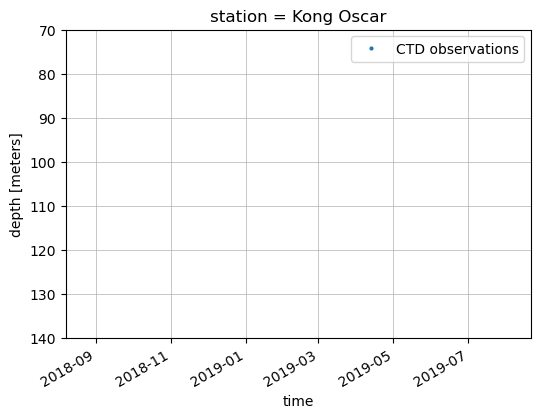

OMG_Narwhals_Mooring_CTD_L2_03716526_20180825.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 164900)
Coordinates:
  * station                (station) <U10 'Kong Oscar'
  * time                   (time) datetime64[ns] 2018-08-25T00:00:01 ... 2019...
Data variables:
    latitude               (station) float64 75.84
    longitude              (station) float64 -59.84
    conductivity           (station, time) float64 2.885 2.891 ... 2.914 2.918
    density                (station, time) float64 1.028e+03 ... 1.028e+03
    depth                  (station, time) float64 233.2 233.2 ... 257.1 257.2
    potential_temperature  (station, time) float64 0.6513 0.6524 ... 0.9028
    pressure               (station, time) float64 235.8 235.8 ... 260.0 260.0
    salinity               (station, time) float64 33.87 33.95 ... 34.0 34.01
    temperature            (station, time) float64 0.6611 0.6622 ... 0.9142
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2018-08-25T00:00:01
    time_coverage_end:             2019-08-03T12:57:01
    time_coverage_duration:        P343DT12H57M0S
    date_created:                  2023-06-28T17:36:18

In [5]:
# process data:

# extract metadata
data = metadata.loc[metadata['filename'] == filename] # select row for cnv file 'filename'
glacier_front = data.glacier_front.values[0]
lat = data.lat.values[0]
lon = data.lon.values[0]
bottom_depth = data.bottom_depth.values[0]

if year == 2019:
    file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE37/" + filename) # 2019
if year == 2020:
    file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE37/" + filename) # 2020

uuid = data.uuid_L2.values[0]
depth_target = data.depth_target.values[0]
depth_actual = data.depth_actual.values[0]

## extract data and create dataset
data_lines, device_type, serial_number, start_time_dt64, sample_interval_td64, sample_interval_iso, var_names = omg37_funs.open_omg_file(file)
mooring_ds, start_time, end_time = omg37_funs.create_Dataset(glacier_front, data_lines, start_time_dt64, sample_interval_td64, lat, lon)

## Save xarray DataSet object as netcdf
num_times = len(mooring_ds.time)

# trim data to remove observations that were on the deck during deployment/recovery
if year == 2019:
    if glacier_front=='Sverdrup glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-24","2019-08-02T12")) 
        print('data successfully trimmed')
    elif glacier_front=='Kong Oscar glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-25","2019-08-03T12"))
        print('data successfully trimmed')
    else: 
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-08-04T12"))
        print('data successfully trimmed')
    
if year == 2020:
    if glacier_front=='Kong Oscar glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-04T14","2020-08-10T09")) 
        print('data successfully trimmed')
    else: 
        mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-05T20","2020-08-10T09"))
        print('data successfully trimmed')

# plot trimmed data with flagged points in red
plt.figure(figsize = [6,4])
mooring_ds_truncated.isel(station=0).depth.plot.line('o', linewidth=0.5, markersize=2, zorder=3, label='CTD observations')
# plt.scatter(mooring_ds_truncated.isel(station=0).time.values[np.where(mooring_ds_truncated.flag_depth == 1)], \
#             mooring_ds_truncated.isel(station=0).depth.values[np.where(mooring_ds_truncated.flag_depth == 1)], \
#             s=3, color='r', zorder=4, label='depth_flag')
plt.grid(linewidth=0.5)
# plt.ylim(140,70)
plt.legend()
plt.show()

# create netcdf filename:
# “OMG_Narwhals_Mooring_<instrument>_L1_<time_coverage_start>.nc"
date_str = str(mooring_ds_truncated.isel(station=0).isel(time=0).time.values)
yymmdd = date_str[0:4] + date_str[5:7] + date_str[8:10]
netcdf_filename = 'OMG_Narwhals_Mooring_CTD_L2_' + serial_number + '_' + yymmdd + '.nc'
print(netcdf_filename)

# add metadata
mooring_ds_final = omg37_funs.add_metadata(mooring_ds_truncated, uuid, glacier_front, bottom_depth, netcdf_filename,\
                                           serial_number, device_type, depth_target, depth_actual, sample_interval_iso)

## Create NetCDF variable encoding (required to save the time values properly)
new_encoding = omg37_funs.create_encoding(mooring_ds_final)

netcdf_filename = Path(netcdf_filename)
mooring_ds_final.to_netcdf(output_dir / netcdf_filename, encoding=new_encoding)
mooring_ds_final.close()

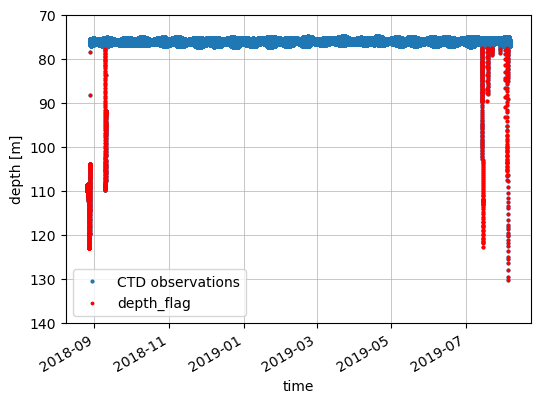

In [51]:
# plot for user guide
plt.figure(figsize = [6,4])
mooring_ds_truncated.depth.plot.line('o', linewidth=0.5, markersize=2, zorder=3, label='CTD observations')
# plt.scatter(mooring_ds_truncated.time, mooring_ds_truncated.depth, s=3)
plt.scatter(mooring_ds_truncated.time.values[np.where(mooring_ds_truncated.flag_depth == 1)], \
            mooring_ds_truncated.depth.values[np.where(mooring_ds_truncated.flag_depth == 1)], \
            s=3, color='r', zorder=4, label='depth_flag')
plt.grid(linewidth=0.5)
plt.ylim(140,70)
plt.legend();
plt.savefig('C:/Users/marie/Documents/PhD/Chapter_3/user_guides/depth_flag_ex.png', bbox_inches='tight')

## Code used to process all files within directory

### Process all data in directory

In [6]:
years = [2019, 2020]

number data lines 165403
number header lines 312 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716526'>
2018-08-25T00:00:01
before
[237.000012 237.002095 237.004178 237.006262 237.008345]

after
[numpy.datetime64('2018-08-25T00:00:01'),
 numpy.datetime64('2018-08-25T00:03:01'),
 numpy.datetime64('2018-08-25T00:06:01'),
 numpy.datetime64('2018-08-25T00:09:01'),
 numpy.datetime64('2018-08-25T00:12:01')]
recording start time:  2018-08-25T00:00:01
recording end time:  2019-08-04T14:06:01
data successfully trimmed


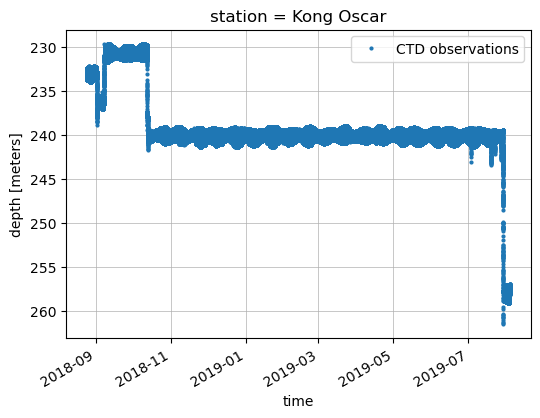

OMG_Narwhals_Mooring_CTD_L2_03716526_20180825.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 164900)
Coordinates:
  * station                (station) <U10 'Kong Oscar'
  * time                   (time) datetime64[ns] 2018-08-25T00:00:01 ... 2019...
Data variables:
    latitude               (station) float64 75.84
    longitude              (station) float64 -59.84
    conductivity           (station, time) float64 2.885 2.891 ... 2.914 2.918
    density                (station, time) float64 1.028e+03 ... 1.028e+03
    depth                  (station, time) float64 233.2 233.2 ... 257.1 257.2
    potential_temperature  (station, time) float64 0.6513 0.6524 ... 0.9028
    pressure               (station, time) float64 235.8 235.8 ... 260.0 260.0
    salinity               (station, time) float64 33.87 33.95 ... 34.0 34.01
    temperature            (station, time) float64 0.6611 0.6622 ... 0.9142
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2018-08-25T00:00:01
    time_coverage_end:             2019-08-03T12:57:01
    time_coverage_duration:        P343DT12H57M0S
    date_created:                  2023-06-28T17:40:20

number data lines 165385
number header lines 310 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716754'>
2018-08-25T00:00:01
before
[237.000012 237.002095 237.004178 237.006262 237.008345]

after
[numpy.datetime64('2018-08-25T00:00:01'),
 numpy.datetime64('2018-08-25T00:03:01'),
 numpy.datetime64('2018-08-25T00:06:01'),
 numpy.datetime64('2018-08-25T00:09:01'),
 numpy.datetime64('2018-08-25T00:12:01')]
recording start time:  2018-08-25T00:00:01
recording end time:  2019-08-04T13:12:01
data successfully trimmed


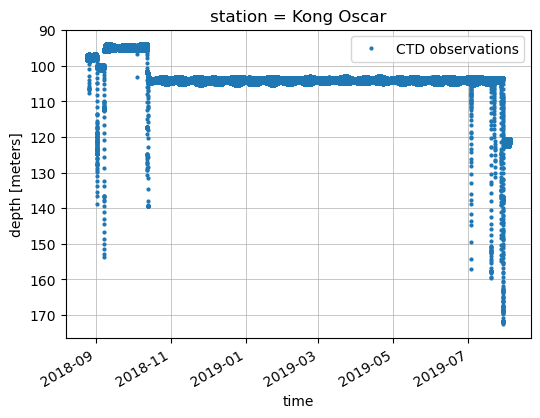

OMG_Narwhals_Mooring_CTD_L2_03716754_20180825.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 164900)
Coordinates:
  * station                (station) <U10 'Kong Oscar'
  * time                   (time) datetime64[ns] 2018-08-25T00:00:01 ... 2019...
Data variables:
    latitude               (station) float64 75.84
    longitude              (station) float64 -59.84
    conductivity           (station, time) float64 2.706 2.738 ... 2.865 2.866
    density                (station, time) float64 1.027e+03 ... 1.028e+03
    depth                  (station, time) float64 97.91 97.92 ... 120.7 120.7
    potential_temperature  (station, time) float64 -0.6351 -0.6251 ... 0.696
    pressure               (station, time) float64 98.96 98.98 ... 122.0 122.0
    salinity               (station, time) float64 33.0 33.43 ... 33.64 33.65
    temperature            (station, time) float64 -0.6324 -0.6223 ... 0.7009
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2018-08-25T00:00:01
    time_coverage_end:             2019-08-03T12:57:01
    time_coverage_duration:        P343DT12H57M0S
    date_created:                  2023-06-28T17:40:36

number data lines 165499
number header lines 299 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716787'>
2018-08-24T00:00:01
before
[236.000012 236.002095 236.004178 236.006262 236.008345]

after
[numpy.datetime64('2018-08-24T00:00:01'),
 numpy.datetime64('2018-08-24T00:03:01'),
 numpy.datetime64('2018-08-24T00:06:01'),
 numpy.datetime64('2018-08-24T00:09:01'),
 numpy.datetime64('2018-08-24T00:12:01')]
recording start time:  2018-08-24T00:00:01
recording end time:  2019-08-03T18:54:01
data successfully trimmed


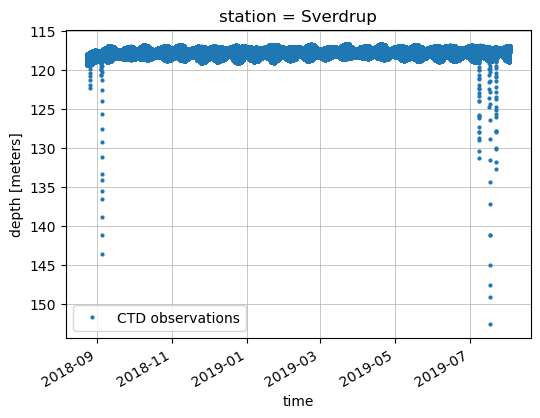

OMG_Narwhals_Mooring_CTD_L2_03716787_20180824.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 164900)
Coordinates:
  * station                (station) <U8 'Sverdrup'
  * time                   (time) datetime64[ns] 2018-08-24T00:00:01 ... 2019...
Data variables:
    latitude               (station) float64 75.54
    longitude              (station) float64 -58.41
    conductivity           (station, time) float64 2.816 2.84 ... 2.834 2.833
    density                (station, time) float64 1.027e+03 ... 1.027e+03
    depth                  (station, time) float64 119.0 119.0 ... 117.3 117.3
    potential_temperature  (station, time) float64 0.4506 0.4498 ... 0.4325
    pressure               (station, time) float64 120.3 120.3 ... 118.6 118.6
    salinity               (station, time) float64 33.26 33.58 ... 33.51 33.51
    temperature            (station, time) float64 0.4551 0.4544 ... 0.449 0.437
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2018-08-24T00:00:01
    time_coverage_end:             2019-08-02T12:57:01
    time_coverage_duration:        P343DT12H57M0S
    date_created:                  2023-06-28T17:40:54

number data lines 165351
number header lines 312 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716788'>
2018-08-26T00:00:01
before
[238.000012 238.002095 238.004178 238.006262 238.008345]

after
[numpy.datetime64('2018-08-26T00:00:01'),
 numpy.datetime64('2018-08-26T00:03:01'),
 numpy.datetime64('2018-08-26T00:06:01'),
 numpy.datetime64('2018-08-26T00:09:01'),
 numpy.datetime64('2018-08-26T00:12:01')]
recording start time:  2018-08-26T00:00:01
recording end time:  2019-08-05T11:30:01
data successfully trimmed


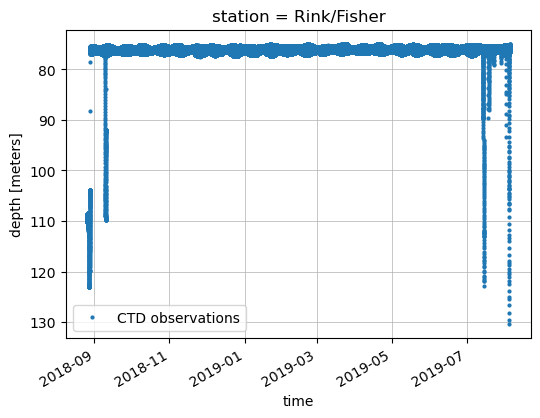

OMG_Narwhals_Mooring_CTD_L2_03716788_20180826.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 164900)
Coordinates:
  * station                (station) <U11 'Rink/Fisher'
  * time                   (time) datetime64[ns] 2018-08-26T00:00:01 ... 2019...
Data variables:
    latitude               (station) float64 76.16
    longitude              (station) float64 -61.28
    conductivity           (station, time) float64 2.7 2.714 ... 2.731 2.731
    density                (station, time) float64 1.027e+03 ... 1.027e+03
    depth                  (station, time) float64 109.5 109.5 ... 75.14 75.14
    potential_temperature  (station, time) float64 -0.9294 -0.9272 ... -0.5472
    pressure               (station, time) float64 110.7 110.7 ... 75.94 75.94
    salinity               (station, time) float64 33.24 33.43 ... 33.26 33.26
    temperature            (station, time) float64 -0.9266 -0.9243 ... -0.545
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2018-08-26T00:00:01
    time_coverage_end:             2019-08-04T12:57:01
    time_coverage_duration:        P343DT12H57M0S
    date_created:                  2023-06-28T17:41:10

number data lines 165386
number header lines 312 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716789'>
2018-08-26T00:00:01
before
[238.000012 238.002095 238.004178 238.006262 238.008345]

after
[numpy.datetime64('2018-08-26T00:00:01'),
 numpy.datetime64('2018-08-26T00:03:01'),
 numpy.datetime64('2018-08-26T00:06:01'),
 numpy.datetime64('2018-08-26T00:09:01'),
 numpy.datetime64('2018-08-26T00:12:01')]
recording start time:  2018-08-26T00:00:01
recording end time:  2019-08-05T13:15:01
data successfully trimmed


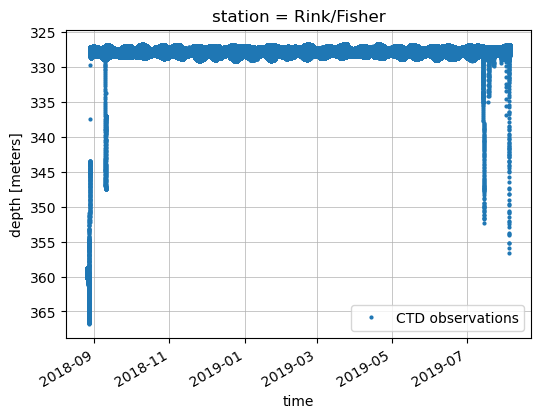

OMG_Narwhals_Mooring_CTD_L2_03716789_20180826.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 164900)
Coordinates:
  * station                (station) <U11 'Rink/Fisher'
  * time                   (time) datetime64[ns] 2018-08-26T00:00:01 ... 2019...
Data variables:
    latitude               (station) float64 76.16
    longitude              (station) float64 -61.28
    conductivity           (station, time) float64 2.991 3.005 ... 2.995 2.995
    density                (station, time) float64 1.029e+03 ... 1.029e+03
    depth                  (station, time) float64 359.5 359.5 ... 326.9 326.9
    potential_temperature  (station, time) float64 1.679 1.675 ... 1.559 1.559
    pressure               (station, time) float64 363.6 363.6 ... 330.6 330.6
    salinity               (station, time) float64 34.03 34.21 ... 34.24 34.24
    temperature            (station, time) float64 1.698 1.694 ... 1.576 1.576
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2018-08-26T00:00:01
    time_coverage_end:             2019-08-04T12:57:01
    time_coverage_duration:        P343DT12H57M0S
    date_created:                  2023-06-28T17:41:26

number data lines 165522
number header lines 307 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716790'>
2018-08-24T00:00:01
before
[236.000012 236.002095 236.004178 236.006262 236.008345]

after
[numpy.datetime64('2018-08-24T00:00:01'),
 numpy.datetime64('2018-08-24T00:03:01'),
 numpy.datetime64('2018-08-24T00:06:01'),
 numpy.datetime64('2018-08-24T00:09:01'),
 numpy.datetime64('2018-08-24T00:12:01')]
recording start time:  2018-08-24T00:00:01
recording end time:  2019-08-03T20:03:01
data successfully trimmed


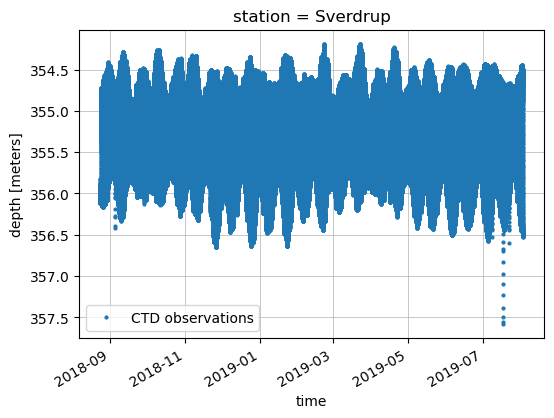

OMG_Narwhals_Mooring_CTD_L2_03716790_20180824.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 164900)
Coordinates:
  * station                (station) <U8 'Sverdrup'
  * time                   (time) datetime64[ns] 2018-08-24T00:00:01 ... 2019...
Data variables:
    latitude               (station) float64 75.54
    longitude              (station) float64 -58.41
    conductivity           (station, time) float64 2.955 2.963 ... 2.957 2.957
    density                (station, time) float64 1.029e+03 ... 1.029e+03
    depth                  (station, time) float64 355.8 355.8 ... 354.9 354.9
    potential_temperature  (station, time) float64 1.224 1.23 ... 1.144 1.143
    pressure               (station, time) float64 359.9 359.9 ... 358.9 358.9
    salinity               (station, time) float64 34.06 34.17 ... 34.18 34.18
    temperature            (station, time) float64 1.241 1.247 ... 1.161 1.161
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2018-08-24T00:00:01
    time_coverage_end:             2019-08-02T12:57:01
    time_coverage_duration:        P343DT12H57M0S
    date_created:                  2023-06-28T17:41:42

number data lines 401570
number header lines 306 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716526'>
2019-08-05T09:00:01
before
[217.375012 217.377095 217.379178 217.381262 217.383345]

after
[numpy.datetime64('2019-08-05T09:00:01'),
 numpy.datetime64('2019-08-05T09:03:01'),
 numpy.datetime64('2019-08-05T09:06:01'),
 numpy.datetime64('2019-08-05T09:09:01'),
 numpy.datetime64('2019-08-05T09:12:01')]
recording start time:  2019-08-05T09:00:01
recording end time:  2021-11-18T23:27:01
data successfully trimmed


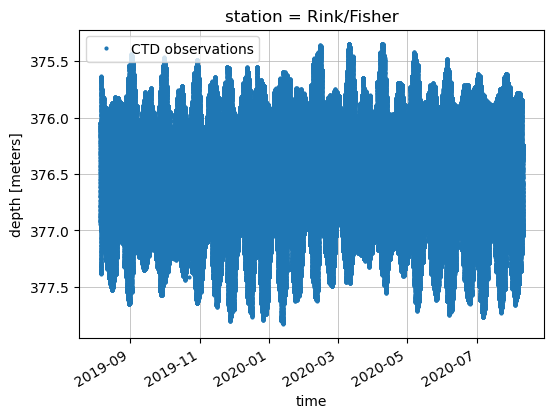

OMG_Narwhals_Mooring_CTD_L2_03716526_20190805.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 177880)
Coordinates:
  * station                (station) <U11 'Rink/Fisher'
  * time                   (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020...
Data variables:
    latitude               (station) float64 76.1
    longitude              (station) float64 -61.73
    conductivity           (station, time) float64 3.028 3.028 ... 3.01 3.011
    density                (station, time) float64 1.029e+03 ... 1.029e+03
    depth                  (station, time) float64 376.9 376.9 ... 376.6 376.6
    potential_temperature  (station, time) float64 1.789 1.79 ... 1.61 1.613
    pressure               (station, time) float64 381.3 381.2 ... 380.9 380.9
    salinity               (station, time) float64 34.37 34.37 ... 34.34 34.34
    temperature            (station, time) float64 1.809 1.81 ... 1.629 1.633
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2019-08-05T20:00:01
    time_coverage_end:             2020-08-10T09:57:01
    time_coverage_duration:        P370DT13H57M0S
    date_created:                  2023-06-28T17:42:17

number data lines 401604
number header lines 306 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716754'>
2019-08-05T09:00:01
before
[217.375012 217.377095 217.379178 217.381262 217.383345]

after
[numpy.datetime64('2019-08-05T09:00:01'),
 numpy.datetime64('2019-08-05T09:03:01'),
 numpy.datetime64('2019-08-05T09:06:01'),
 numpy.datetime64('2019-08-05T09:09:01'),
 numpy.datetime64('2019-08-05T09:12:01')]
recording start time:  2019-08-05T09:00:01
recording end time:  2021-11-19T01:09:01
data successfully trimmed


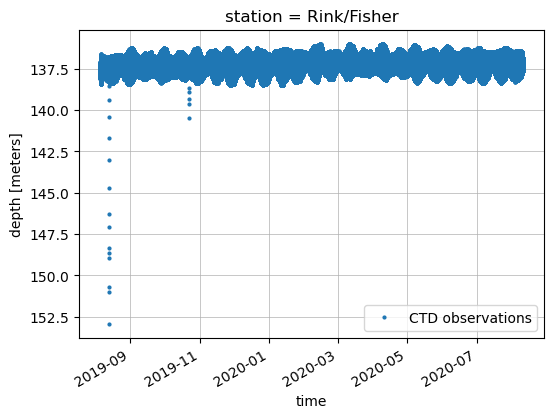

OMG_Narwhals_Mooring_CTD_L2_03716754_20190805.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 177880)
Coordinates:
  * station                (station) <U11 'Rink/Fisher'
  * time                   (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020...
Data variables:
    latitude               (station) float64 76.1
    longitude              (station) float64 -61.73
    conductivity           (station, time) float64 2.772 2.773 ... 2.788 2.788
    density                (station, time) float64 1.028e+03 ... 1.028e+03
    depth                  (station, time) float64 138.1 138.1 ... 137.2 137.2
    potential_temperature  (station, time) float64 -0.3806 -0.3778 ... -0.2431
    pressure               (station, time) float64 139.6 139.6 ... 138.7 138.7
    salinity               (station, time) float64 33.59 33.59 ... 33.64 33.64
    temperature            (station, time) float64 -0.3763 -0.3734 ... -0.2386
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2019-08-05T20:00:01
    time_coverage_end:             2020-08-10T09:57:01
    time_coverage_duration:        P370DT13H57M0S
    date_created:                  2023-06-28T17:42:51

number data lines 402069
number header lines 306 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716787'>
2019-08-04T09:00:01
before
[216.375012 216.377095 216.379178 216.381262 216.383345]

after
[numpy.datetime64('2019-08-04T09:00:01'),
 numpy.datetime64('2019-08-04T09:03:01'),
 numpy.datetime64('2019-08-04T09:06:01'),
 numpy.datetime64('2019-08-04T09:09:01'),
 numpy.datetime64('2019-08-04T09:12:01')]
recording start time:  2019-08-04T09:00:01
recording end time:  2021-11-19T00:24:01
data successfully trimmed


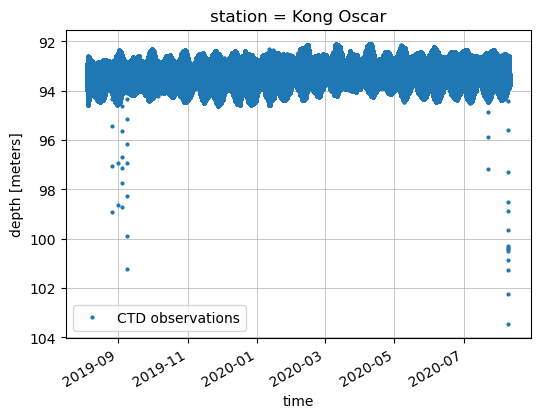

OMG_Narwhals_Mooring_CTD_L2_03716787_20190804.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 178480)
Coordinates:
  * station                (station) <U10 'Kong Oscar'
  * time                   (time) datetime64[ns] 2019-08-04T14:00:01 ... 2020...
Data variables:
    latitude               (station) float64 75.84
    longitude              (station) float64 -59.84
    conductivity           (station, time) float64 2.779 2.78 ... 2.732 2.733
    density                (station, time) float64 1.027e+03 ... 1.027e+03
    depth                  (station, time) float64 92.99 93.0 ... 93.32 93.31
    potential_temperature  (station, time) float64 -0.1229 -0.1155 ... -0.6667
    pressure               (station, time) float64 93.99 94.0 ... 94.32 94.31
    salinity               (station, time) float64 33.43 33.43 ... 33.4 33.41
    temperature            (station, time) float64 -0.1198 -0.1125 ... -0.6641
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2019-08-04T14:00:01
    time_coverage_end:             2020-08-10T09:57:01
    time_coverage_duration:        P371DT19H57M0S
    date_created:                  2023-06-28T17:43:29

number data lines 402040
number header lines 306 

* <HardwareData DeviceType='SBE37SM-RS232' SerialNumber='03716790'>
2019-08-04T09:00:01
before
[216.375012 216.377095 216.379178 216.381262 216.383345]

after
[numpy.datetime64('2019-08-04T09:00:01'),
 numpy.datetime64('2019-08-04T09:03:01'),
 numpy.datetime64('2019-08-04T09:06:01'),
 numpy.datetime64('2019-08-04T09:09:01'),
 numpy.datetime64('2019-08-04T09:12:01')]
recording start time:  2019-08-04T09:00:01
recording end time:  2021-11-18T22:57:01
data successfully trimmed


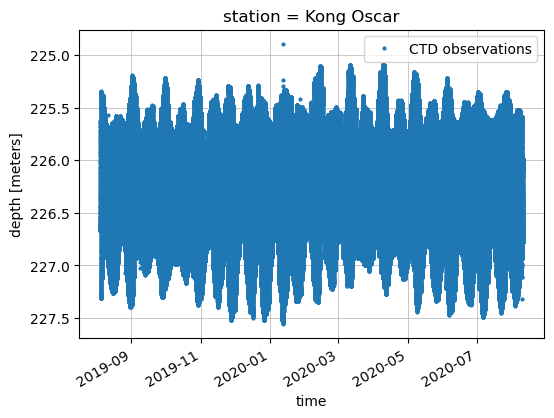

OMG_Narwhals_Mooring_CTD_L2_03716790_20190804.nc


<xarray.Dataset>
Dimensions:                (station: 1, time: 178480)
Coordinates:
  * station                (station) <U10 'Kong Oscar'
  * time                   (time) datetime64[ns] 2019-08-04T14:00:01 ... 2020...
Data variables:
    latitude               (station) float64 75.84
    longitude              (station) float64 -59.84
    conductivity           (station, time) float64 2.914 2.913 ... 2.891 2.891
    density                (station, time) float64 1.028e+03 ... 1.028e+03
    depth                  (station, time) float64 225.6 225.6 ... 226.3 226.3
    potential_temperature  (station, time) float64 0.8748 0.8731 ... 0.65 0.6475
    pressure               (station, time) float64 228.1 228.1 ... 228.8 228.8
    salinity               (station, time) float64 34.0 34.0 ... 33.96 33.96
    temperature            (station, time) float64 0.8847 0.883 ... 0.6569
Attributes: (12/57)
    title:                         OMG Narwhals Moored CTD Level 2 Data
    summary:                       This dataset contains conductivity, temper...
    keywords:                      Conductivity, Salinity, Water Depth, Water...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    ...                            ...
    geospatial_vertical_positive:  down
    time_coverage_resolution:      P180S
    time_coverage_start:           2019-08-04T14:00:01
    time_coverage_end:             2020-08-10T09:57:01
    time_coverage_duration:        P371DT19H57M0S
    date_created:                  2023-06-28T17:43:58

In [9]:
## create a loop that uses the above functions for all mooring data files
## loop through cnvfiles object

for year in years:
    if year == 2019:
        os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE37")
        metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2019/SBE37_metadata_2019.csv")
        # output directory for L2 files
        output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2019')
    if year == 2020:
        os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE37")
        metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2020/SBE37_metadata_2020.csv")
        output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2020')
        
    cnvfiles = []
    for file in glob.glob("*.cnv"):
        cnvfiles.append(file)
    # pprint(cnvfiles)
    
    ## get all metadata associated with each data file
    # read in csv with metadata
    metadata = pd.read_csv(metadata_path)    
    
    for filename in cnvfiles:
        # extract metadata
        data = metadata.loc[metadata['filename'] == filename] # select row for cnv file 'filename'
        glacier_front = data.glacier_front.values[0]
        lat = data.lat.values[0]
        lon = data.lon.values[0]
        bottom_depth = data.bottom_depth.values[0]
        
        if year == 2019:
            file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE37/" + filename) # 2019
        if year == 2020:
            file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE37/" + filename) # 2020
        
        uuid = data.uuid_L2.values[0]
        depth_target = data.depth_target.values[0]
        depth_actual = data.depth_actual.values[0]
        
        ## extract data and create dataset
        data_lines, device_type, serial_number, start_time_dt64, sample_interval_td64, sample_interval_iso, var_names = omg37_funs.open_omg_file(file)
        mooring_ds, start_time, end_time = omg37_funs.create_Dataset(glacier_front, data_lines, start_time_dt64, sample_interval_td64, lat, lon)
        
        ## Save xarray DataSet object as netcdf
        num_times = len(mooring_ds.time)
        
        # trim data to remove observations that were on the deck during deployment/recovery
        if year == 2019:
            if glacier_front=='Sverdrup glacier':
                mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-24","2019-08-02T12")) 
                print('data successfully trimmed')
            elif glacier_front=='Kong Oscar glacier':
                mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-25","2019-08-03T12"))
                print('data successfully trimmed')
            else: 
                mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-08-04T12"))
                print('data successfully trimmed')
            
        if year == 2020:
            if glacier_front=='Kong Oscar glacier':
                mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-04T14","2020-08-10T09")) 
                print('data successfully trimmed')
            else: 
                mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-05T20","2020-08-10T09"))
                print('data successfully trimmed')
        
        # plot trimmed data with flagged points in red
        plt.figure(figsize = [6,4])
        mooring_ds_truncated.isel(station=0).depth.plot.line('o', linewidth=0.5, markersize=2, zorder=3, label='CTD observations')
        # plt.scatter(mooring_ds_truncated.time.values[np.where(mooring_ds_truncated.flag_depth == 1)], \
        #             mooring_ds_truncated.depth.values[np.where(mooring_ds_truncated.flag_depth == 1)], \
        #             s=3, color='r', zorder=4, label='depth_flag')
        plt.grid(linewidth=0.5)
        plt.gca().invert_yaxis()
        plt.legend()
        plt.show()
        
        # create netcdf filename:
        # “OMG_Narwhals_Mooring_<instrument>_L1_<time_coverage_start>.nc"
        date_str = str(mooring_ds_truncated.isel(station=0).isel(time=0).time.values)
        yymmdd = date_str[0:4] + date_str[5:7] + date_str[8:10]
        netcdf_filename = 'OMG_Narwhals_Mooring_CTD_L2_' + serial_number + '_' + yymmdd + '.nc'
        print(netcdf_filename)
        
        # add metadata
        mooring_ds_final = omg37_funs.add_metadata(mooring_ds_truncated, uuid, glacier_front, bottom_depth, netcdf_filename,\
                                                   serial_number, device_type, depth_target, depth_actual, sample_interval_iso)
        
        ## Create NetCDF variable encoding (required to save the time values properly)
        new_encoding = omg37_funs.create_encoding(mooring_ds_final)
        
        netcdf_filename = Path(netcdf_filename)
        mooring_ds_final.to_netcdf(output_dir / netcdf_filename, encoding=new_encoding)
        mooring_ds_final.close()

## Check a file

In [9]:
output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2020/')

In [10]:
netcdf_filename = 'OMG_Narwhals_Mooring_CTD_L2_03716754_20190805.nc'

In [11]:
tmp = xr.open_dataset(output_dir / netcdf_filename)
tmp.close()

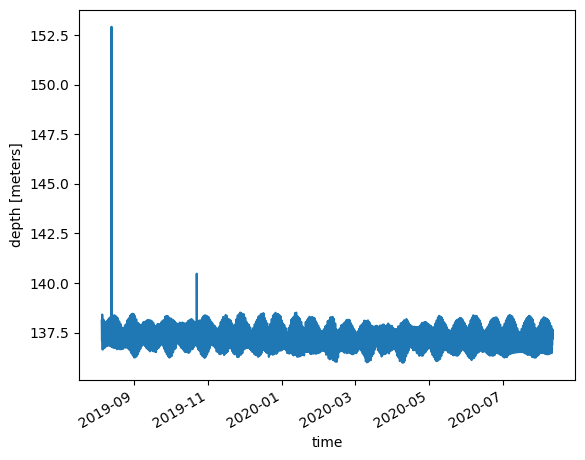

In [12]:
tmp.depth.plot()

In [14]:
tmp.flag_depth

<xarray.DataArray 'flag_depth' (time: 177880)>
[177880 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020-08-10T09:57:01
Attributes:
    long_name:              quality flag for depth measurements
    standard_name:          quality_flag
    units:                  1
    flag_values:            [0 1]
    flag_meanings:          ['depth_consistent', 'depth_spike']
    coverage_content_type:  qualityInformation
    comments:               Recommended to use flag_depth=0 for consistent re...

In [12]:
tmp.assign_coords(latitude=tmp.mooring_latitude)

<xarray.Dataset>
Dimensions:                (time: 177880)
Coordinates:
  * time                   (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020...
    latitude               float64 76.1
Data variables:
    conductivity           (time) float64 ...
    density                (time) float64 ...
    depth                  (time) float64 ...
    potential_temperature  (time) float64 ...
    pressure               (time) float64 ...
    salinity               (time) float64 ...
    temperature            (time) float64 ...
    flag_depth             (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals Moored CTD Level 2 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Salinity, Water Depth, Water Tempe...
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L2
    ...                      ...
    geospatial_lon_max:      -61.726983
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2019-08-05T20:00:01
    time_coverage_end:       2020-08-10T09:57:01
    time_coverage_duration:  P370DT13H57M0S
    date_created:            2023-06-27T15:38:45

***
# Create L1 netCDFs from L2 netCDFs

In [16]:
years = [2019, 2020]

OMG_Narwhals_Mooring_CTD_L1_03716526_20180825.nc


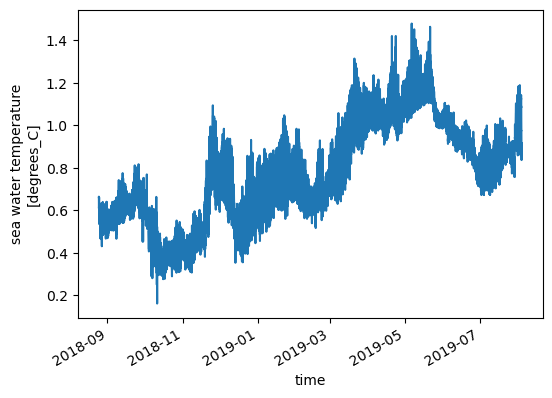

<xarray.Dataset>
Dimensions:       (time: 164900)
Coordinates:
  * time          (time) datetime64[ns] 2018-08-25T00:00:01 ... 2019-08-03T12...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -59.8429
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2018-08-25T00:00:01
    time_coverage_end:       2019-08-04T14:06:01
    time_coverage_duration:  P344DT14H6M0S
    date_created:            2023-06-26T22:36:50

OMG_Narwhals_Mooring_CTD_L1_03716754_20180825.nc


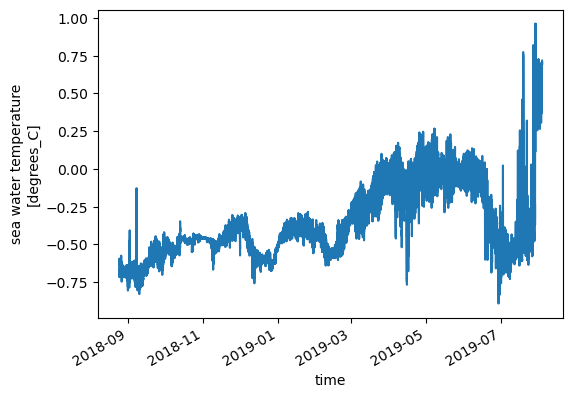

<xarray.Dataset>
Dimensions:       (time: 164900)
Coordinates:
  * time          (time) datetime64[ns] 2018-08-25T00:00:01 ... 2019-08-03T12...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -59.8429
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2018-08-25T00:00:01
    time_coverage_end:       2019-08-04T13:12:01
    time_coverage_duration:  P344DT13H12M0S
    date_created:            2023-06-26T22:37:03

OMG_Narwhals_Mooring_CTD_L1_03716787_20180824.nc


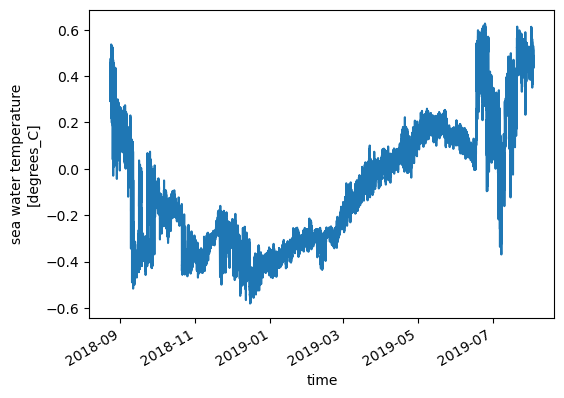

<xarray.Dataset>
Dimensions:       (time: 164900)
Coordinates:
  * time          (time) datetime64[ns] 2018-08-24T00:00:01 ... 2019-08-02T12...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -58.410533
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2018-08-24T00:00:01
    time_coverage_end:       2019-08-03T18:54:01
    time_coverage_duration:  P344DT18H54M0S
    date_created:            2023-06-26T22:37:15

OMG_Narwhals_Mooring_CTD_L1_03716788_20180826.nc


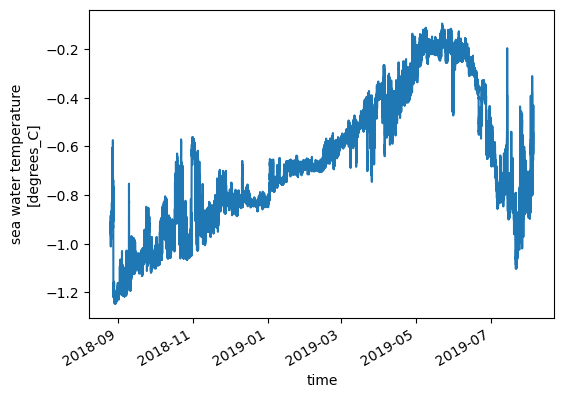

<xarray.Dataset>
Dimensions:       (time: 164900)
Coordinates:
  * time          (time) datetime64[ns] 2018-08-26T00:00:01 ... 2019-08-04T12...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -61.279117
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2018-08-26T00:00:01
    time_coverage_end:       2019-08-05T11:30:01
    time_coverage_duration:  P344DT11H30M0S
    date_created:            2023-06-26T22:37:30

OMG_Narwhals_Mooring_CTD_L1_03716789_20180826.nc


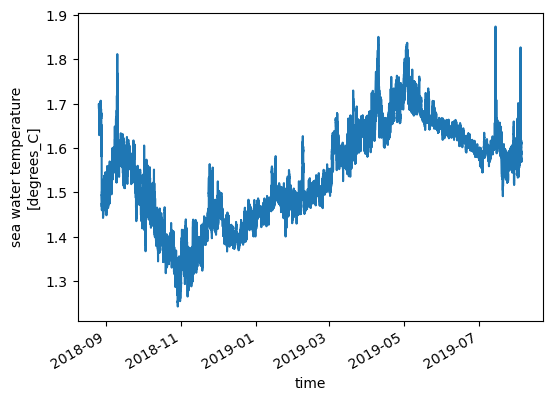

<xarray.Dataset>
Dimensions:       (time: 164900)
Coordinates:
  * time          (time) datetime64[ns] 2018-08-26T00:00:01 ... 2019-08-04T12...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -61.279117
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2018-08-26T00:00:01
    time_coverage_end:       2019-08-05T13:15:01
    time_coverage_duration:  P344DT13H15M0S
    date_created:            2023-06-26T22:37:43

OMG_Narwhals_Mooring_CTD_L1_03716790_20180824.nc


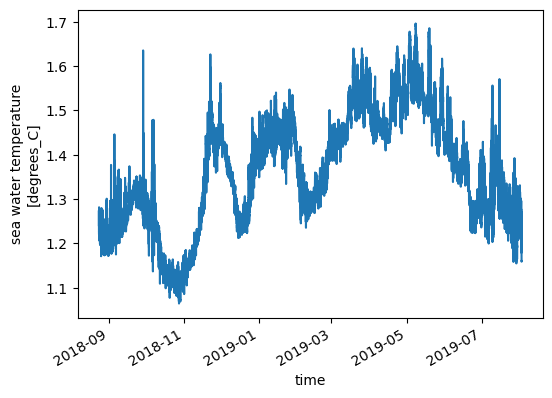

<xarray.Dataset>
Dimensions:       (time: 164900)
Coordinates:
  * time          (time) datetime64[ns] 2018-08-24T00:00:01 ... 2019-08-02T12...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -58.410533
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2018-08-24T00:00:01
    time_coverage_end:       2019-08-03T20:03:01
    time_coverage_duration:  P344DT20H3M0S
    date_created:            2023-06-26T22:37:53

OMG_Narwhals_Mooring_CTD_L1_03716526_20190805.nc


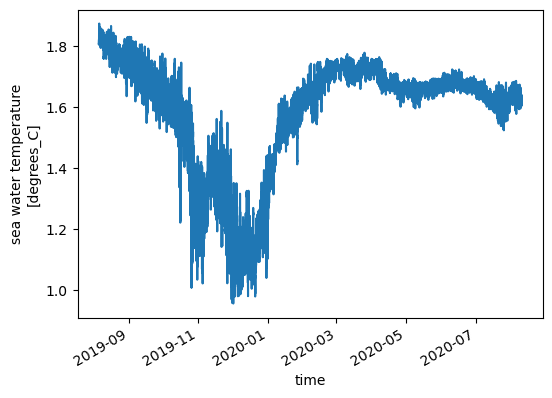

<xarray.Dataset>
Dimensions:       (time: 177880)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020-08-10T09...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -61.726983
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2019-08-05T09:00:01
    time_coverage_end:       2021-11-18T23:27:01
    time_coverage_duration:  P836DT14H27M0S
    date_created:            2023-06-26T22:38:16

OMG_Narwhals_Mooring_CTD_L1_03716754_20190805.nc


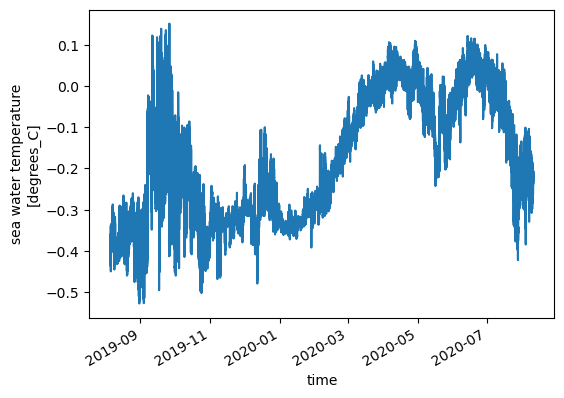

<xarray.Dataset>
Dimensions:       (time: 177880)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020-08-10T09...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -61.726983
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2019-08-05T09:00:01
    time_coverage_end:       2021-11-19T01:09:01
    time_coverage_duration:  P836DT16H9M0S
    date_created:            2023-06-26T22:38:41

OMG_Narwhals_Mooring_CTD_L1_03716787_20190804.nc


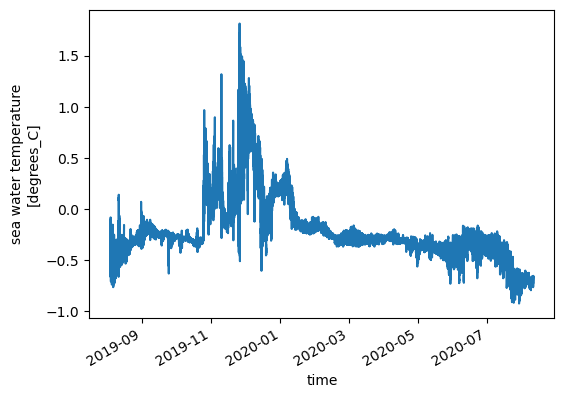

<xarray.Dataset>
Dimensions:       (time: 178480)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-04T14:00:01 ... 2020-08-10T09...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -59.843117
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2019-08-04T09:00:01
    time_coverage_end:       2021-11-19T00:24:01
    time_coverage_duration:  P837DT15H24M0S
    date_created:            2023-06-26T22:39:02

OMG_Narwhals_Mooring_CTD_L1_03716790_20190804.nc


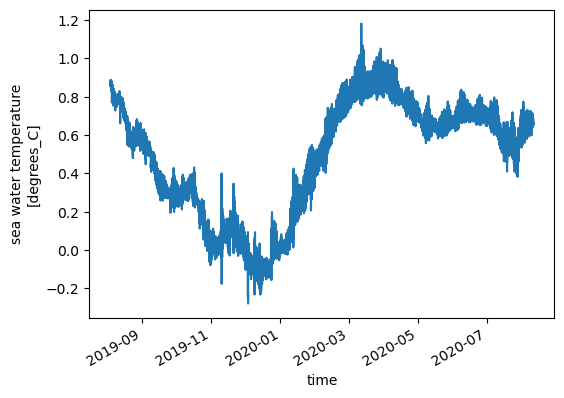

<xarray.Dataset>
Dimensions:       (time: 178480)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-04T14:00:01 ... 2020-08-10T09...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -59.843117
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2019-08-04T09:00:01
    time_coverage_end:       2021-11-18T22:57:01
    time_coverage_duration:  P837DT13H57M0S
    date_created:            2023-06-26T22:39:24

In [17]:
for year in years:
    ## define output directory for L1 files and directory to import L2 files
    if year == 2019:
        output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2019/SBE37/')
        os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2019")
        metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2019/SBE37_metadata_2019.csv")
    if year == 2020:
        output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2020/SBE37/')
        os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2020")
        metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2020/SBE37_metadata_2020.csv")

    ## get all metadata associated with each data file
    # read in csv with metadata
    metadata = pd.read_csv(metadata_path)    
    
    ## get names of all netcdf files in L2 directory
    nc_files = []
    for file in glob.glob("*.nc"):
        nc_files.append(file)
    # print(nc_files)
    
    ## loop to run through L2 files and modify to make L1
    for filename in nc_files:
    
        data = metadata.loc[metadata['filename_L2'] == filename] # select row for cnv file 'filename'
        
        if year == 2019:
            file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2019/" + filename) # 2019 data
        if year == 2020:
            file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L2/2020/" + filename) # 2020 data
            
        uuid = data.uuid_L1.values[0]
        netcdf_filename = 'OMG_Narwhals_Mooring_CTD_L1' + filename[27:]
        print(netcdf_filename)
        
        # read in L2 netCDF file
        sbe37data = xr.open_dataset(file)
        sbe37data.close()
        # remove derived variables: salinity, density, and potential temperature
        sbe37data_L1 = sbe37data.drop(labels = ['salinity', 'density', 'potential_temperature'])
        sbe37data_L1
        
        ## change global attributes for L1 dataset
        sbe37data_L1.attrs['title'] = 'OMG Narwhals mooring CTD Level 1 Data'
        sbe37data_L1.attrs['summary'] = 'This dataset contains conductivity, temperature, pressure, and depth measurements from a CTD instrument that was attached to an ocean mooring. This dataset was collected by the Oceans Melting Greenland (OMG) Narwhals program that will provide subannual hydrographic variability measurements in three northwest Greenland fjords. Between July 2018 to July 2020, three bottom-mounted moorings with a suite of instrumentation were deployed year-round in three glacial fjord sites in Melville Bay, West Greenland: Sverdrup Glacier, Kong Oscar Glacier, and Fisher Islands/Rink Glacier. Examination of water properties at these sites will demonstrate the presence and potential seasonality of warm, salty Atlantic Water intrusion into these marine-terminating glaciers. Additonally, during summer cruises where moorings were deployed and/or recovered, a CTD was lowered into the water to obtain full water column profiles at various locations near the glacier fronts and offshore.'
        sbe37data_L1.attrs['keywords'] = 'Conductivity, Water Depth, Water Temperature'
        sbe37data_L1.attrs['id'] = 'OMG_Narwhals_Mooring_CTD_L1'
        sbe37data_L1.attrs['uuid'] = uuid
        sbe37data_L1.attrs['filename'] = netcdf_filename
        sbe37data_L1.attrs['processing_level'] = 'L1'
        
        ## sanity plot
        plt.figure(figsize = [6,4])
        sbe37data_L1.temperature.plot(label = filename)
        plt.show()
        
        with xr.set_options(display_style="html"):
            display(sbe37data_L1)
            
        ## save xarray dataset object as netcdf
        netcdf_filename = Path(netcdf_filename)
        sbe37data_L1.to_netcdf(output_dir / netcdf_filename)
        sbe37data_L1.close()

## Check the file

In [3]:
tmp = xr.open_dataset('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2020/SBE37/OMG_Narwhals_Mooring_CTD_L1_03716526_20190805.nc')
tmp.close()
tmp

<xarray.Dataset>
Dimensions:       (time: 177880)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020-08-10T09...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 ...
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -61.726983
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2019-08-05T09:00:01
    time_coverage_end:       2021-11-18T23:27:01
    time_coverage_duration:  P836DT14H27M0S
    date_created:            2023-06-26T22:38:16

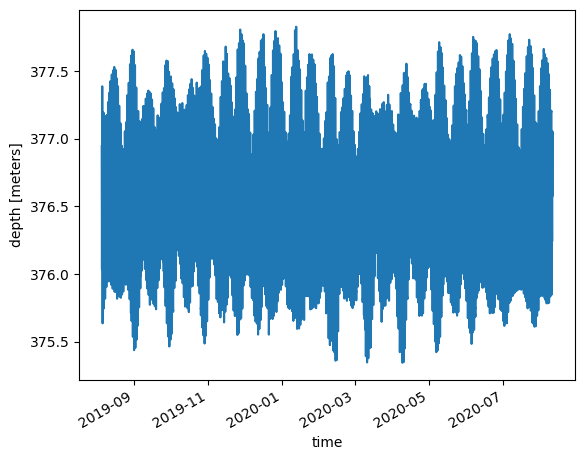

In [4]:
tmp.depth.plot()

In [5]:
tmp.time.attrs['long_name'] ='time'

In [11]:
np.shape([tmp.temperature.values])

(1, 177880)

In [12]:
tmp

<xarray.Dataset>
Dimensions:       (time: 177880)
Coordinates:
  * time          (time) datetime64[ns] 2019-08-05T20:00:01 ... 2020-08-10T09...
Data variables:
    conductivity  (time) float64 ...
    depth         (time) float64 ...
    pressure      (time) float64 ...
    temperature   (time) float64 1.809 1.81 1.81 1.808 ... 1.628 1.629 1.633
    flag_depth    (time) float64 ...
Attributes: (12/52)
    title:                   OMG Narwhals mooring CTD Level 1 Data
    summary:                 This dataset contains conductivity, temperature,...
    keywords:                Conductivity, Water Depth, Water Temperature
    keywords_vocabulary:     NASA Global Change Master Directory (GCMD) Scien...
    Conventions:             CF-1.8, ACDD-1.3
    id:                      OMG_Narwhals_Mooring_CTD_L1
    ...                      ...
    geospatial_lon_max:      -61.726983
    geospatial_lon_units:    degrees_east
    time_coverage_start:     2019-08-05T09:00:01
    time_coverage_end:       2021-11-18T23:27:01
    time_coverage_duration:  P836DT14H27M0S
    date_created:            2023-06-26T22:38:16

In [14]:
tmp.depth.min().values

array(375.344)

In [16]:
pd.Timedelta(seconds=180).isoformat()

'P0DT0H3M0S'